# Data Loading (Station 41025)

In this section, the historical buoy data for station 41025 is prepared for forecasting analysis. The raw observations are provided as separate compressed (.gz) files for each calendar year, spanning 2014 to 2019. To enable time-series modeling and walk-forward validation, these yearly files must first be combined into a single, continuous dataset.

Each yearly file is read, parsed, and standardized to ensure consistent column naming and timestamp formatting. Invalid or sentinel values used by the buoy system to represent missing measurements are converted to NaN to allow proper handling in later preprocessing steps. A unified datetime index is constructed from the provided year, month, day, and hour fields, and the data are sorted chronologically.

The resulting yearly datasets are then concatenated into one continuous time series covering the full 2014–2019 period. Duplicate timestamps, which may arise at year boundaries or during data overlaps, are removed to ensure temporal consistency.

At this stage, the dataset is not yet resampled, imputed, or feature-engineered. The objective here is solely to produce a clean, chronologically ordered raw time series that will serve as the foundation for subsequent steps, including missing-data analysis, lag-based feature construction, multi-horizon target generation, and forecasting model development.

In [22]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor


In [5]:
# Standard NDBC missing-value codes
NDBC_NA_VALS = [99, 99.0, 999, 999.0, 9999, 9999.0, "MM"]

In [6]:
def read_ndbc_stdmet(path: str) -> pd.DataFrame:
    """
    Read a single NDBC standard meteorological file (.txt).
    - Detects header line starting with '#YY' or 'YY'
    - Uses it as column names
    - Converts standard NDBC missing codes to NaN
    """
    header = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("#YY") or line.startswith("YY"):
                header = line.lstrip("#").strip().split()
                break

    if header is None:
        raise ValueError(f"Could not find NDBC header in {path}")

    df = pd.read_csv(
        path,
        sep=r"\s+",
        comment="#",
        header=None,
        names=header,
        na_values=NDBC_NA_VALS,
        engine="python",
    )

    return df


In [7]:
def build_station_41025(years):
    """
    Build a single cleaned DataFrame for station 41025
    from yearly files like 41025h2014.txt, 41025h2015.txt, ...
    """
    files = sorted(
        f for f in glob.glob("41025h*.txt")
        if any(str(y) in os.path.basename(f) for y in years)
    )

    if not files:
        raise FileNotFoundError(
            "No files found matching 41025h*.txt for years "
            f"{years} in {os.getcwd()}"
        )

    print(f"Found {len(files)} files for station 41025:")
    for f in files:
        print(" -", os.path.basename(f))

    dfs = [read_ndbc_stdmet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)

    # Standardize time columns
    col_map = {
        "#YY": "year", "YY": "year",
        "MM": "month",
        "DD": "day",
        "hh": "hour",
        "mm": "minute"
    }
    df = df.rename(columns={k: v for k, v in col_map.items() if k in df.columns})

    # Build datetime index
    if "minute" not in df.columns:
        df["minute"] = 0

    df["datetime"] = pd.to_datetime(
        df[["year", "month", "day", "hour", "minute"]],
        errors="coerce"
    )

    df = (
        df.dropna(subset=["datetime"])
          .set_index("datetime")
          .sort_index()
    )

    # Drop raw time columns
    df = df.drop(columns=["year", "month", "day", "hour", "minute"], errors="ignore")

    return df


In [8]:
years = [2014, 2015, 2016, 2017, 2018, 2019]

df_41025 = build_station_41025(years)

Found 6 files for station 41025:
 - 41025h2014.txt
 - 41025h2015.txt
 - 41025h2016.txt
 - 41025h2017.txt
 - 41025h2018.txt
 - 41025h2019.txt


In [9]:
keep_cols = [c for c in ["WVHT", "APD", "WSPD", "PRES", "ATMP", "WTMP", "GST"]
             if c in df_41025.columns]

df_41025 = df_41025[keep_cols]

In [10]:
print("Index range:", df_41025.index.min(), "→", df_41025.index.max())
print("Shape:", df_41025.shape)
print("\nMissingness (%):")
print(df_41025.isna().mean().sort_values(ascending=False))

df_41025.head()

Index range: 2013-12-31 23:50:00 → 2019-12-31 23:50:00
Shape: (117882, 7)

Missingness (%):
WVHT    0.624413
APD     0.624413
ATMP    0.068221
WTMP    0.044723
GST     0.009238
WSPD    0.009213
PRES    0.001798
dtype: float64


,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST
datetime,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1


In [12]:
df_41025 = df_41025.asfreq("1H")

C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\110875115.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_41025 = df_41025.asfreq("1H")


In [13]:
df_41025

,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST
datetime,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1
...,...,...,...,...,...,...,...
2019-12-31 19:50:00,NaN,NaN,6.9,1007.6,15.2,22.1,10.0
2019-12-31 20:50:00,NaN,NaN,7.4,1007.8,15.2,22.3,10.0
2019-12-31 21:50:00,NaN,NaN,7.4,1008.2,15.4,22.8,10.0


In [14]:
for col in ["WVHT", "APD"]:
    df_41025[f"{col}_missing"] = df_41025[col].isna().astype(int)

In [15]:
df_41025[["WVHT", "APD"]] = (
    df_41025[["WVHT", "APD"]]
    .interpolate(limit=3, limit_direction="forward")
)

In [16]:
print("Final missingness (%):")
print(df_41025.isna().mean().sort_values(ascending=False))

df_41025.head()


Final missingness (%):
WVHT            0.424094
APD             0.424094
WTMP            0.244766
ATMP            0.226034
GST             0.173795
WSPD            0.173738
PRES            0.156489
WVHT_missing    0.000000
APD_missing     0.000000
dtype: float64


,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST,WVHT_missing,APD_missing
datetime,,,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0,0,0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5,0,0
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5,0,0
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4,0,0
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1,0,0


## Short gaps (≤3 h) were interpolated(fill forward) , while longer gaps were retained as missing and will be excluded from training windows

In [17]:
# Require all core inputs to be present for a window
required_cols = ["WVHT", "APD", "WSPD", "PRES", "ATMP", "WTMP", "GST"]

df_model = df_41025.dropna(subset=required_cols)
print("Model-ready shape:", df_model.shape)


Model-ready shape: (22873, 9)


## Build lag features

In [18]:
L = 24  # 24-hour history

for col in ["WVHT", "APD"]:
    for l in range(1, L + 1):
        df_model[f"{col}_lag{l}"] = df_model[col].shift(l)

df_model = df_model.dropna()
print("After lagging:", df_model.shape)


After lagging: (22849, 57)


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"{col}_lag{l}"] = df_model[col].shift(l)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"{col}_lag{l}"] = df_model[col].shift(l)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

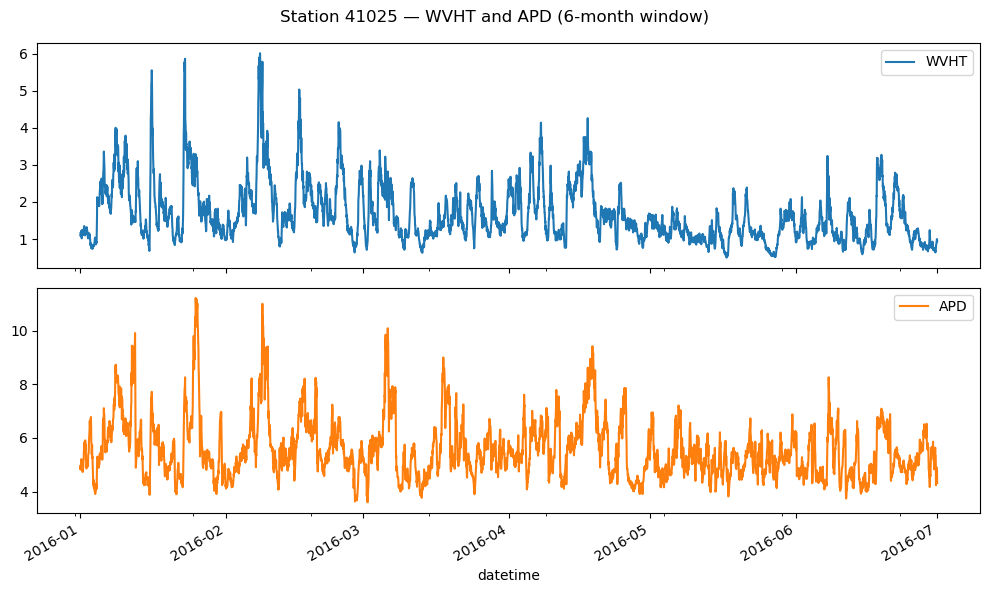

In [20]:
df_41025.loc["2016-01":"2016-06", ["WVHT", "APD"]].plot(
    subplots=True, sharex=True, figsize=(10,6)
)
plt.suptitle("Station 41025 — WVHT and APD (6-month window)")
plt.tight_layout()
plt.show()


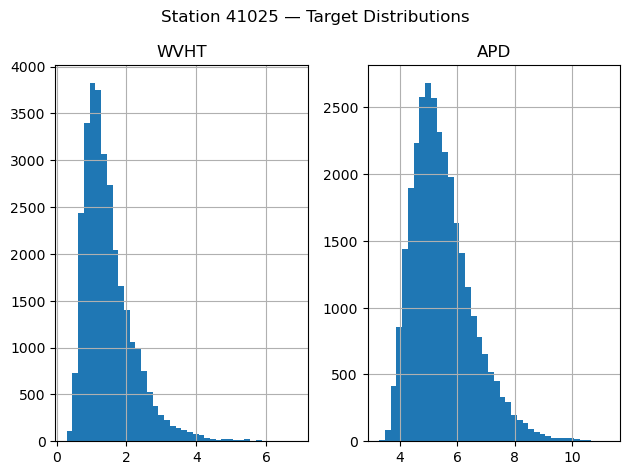

In [21]:
df_41025[["WVHT", "APD"]].hist(bins=40)
plt.suptitle("Station 41025 — Target Distributions")
plt.tight_layout()
plt.show()


In [23]:
df = df_41025.copy()

df = df.sort_index()
print("Index sorted:", df.index.is_monotonic_increasing)
print("Time range:", df.index.min(), "→", df.index.max())
print("Columns:", df.columns.tolist())

df = df.asfreq("1H")

print("\nMissingness (%):")
print((df.isna().mean()*100).sort_values(ascending=False))


Index sorted: True
Time range: 2013-12-31 23:50:00 → 2019-12-31 23:50:00
Columns: ['WVHT', 'APD', 'WSPD', 'PRES', 'ATMP', 'WTMP', 'GST', 'WVHT_missing', 'APD_missing']

Missingness (%):
WVHT            42.409432
APD             42.409432
WTMP            24.476562
ATMP            22.603404
GST             17.379481
WSPD            17.373776
PRES            15.648949
WVHT_missing     0.000000
APD_missing      0.000000
dtype: float64


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\3785020418.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("1H")


## Feature Engineering

In [24]:
def add_time_features(df):
    out = df.copy()
    out["hour"] = out.index.hour
    out["doy"] = out.index.dayofyear
    
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24)
    
    out["doy_sin"] = np.sin(2*np.pi*out["doy"]/365.25)
    out["doy_cos"] = np.cos(2*np.pi*out["doy"]/365.25)
    
    out = out.drop(columns=["hour","doy"])
    return out

df = add_time_features(df)
df.head()


,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST,WVHT_missing,APD_missing,hour_sin,hour_cos,doy_sin,doy_cos
datetime,,,,,,,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0,0,0,-0.258819,0.965926,-0.004301,0.999991
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5,0,0,0.000000,1.000000,0.017202,0.999852
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5,0,0,0.258819,0.965926,0.017202,0.999852
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4,0,0,0.500000,0.866025,0.017202,0.999852
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1,0,0,0.707107,0.707107,0.017202,0.999852


In [25]:
BASE_FEATURES = [c for c in ["WVHT","APD","WSPD","PRES","ATMP","WTMP","GST",
                            "WVHT_missing","APD_missing",
                            "hour_sin","hour_cos","doy_sin","doy_cos"]
                 if c in df.columns]

def make_supervised(df, horizon_h=1, L=24, features=BASE_FEATURES):
    """
    Build X, y for direct forecasting:
    X_t = past L hours of features up to time t (lags 1..L)
    y_t = [WVHT, APD] at time t+horizon_h
    """
    d = df.copy()
    
    # Target (future)
    d["y_wvht"] = d["WVHT"].shift(-horizon_h)
    d["y_apd"]  = d["APD"].shift(-horizon_h)
    
    # Lag features (past only)
    for col in features:
        for lag in range(1, L+1):
            d[f"{col}_lag{lag}"] = d[col].shift(lag)

    # Keep only rows where:
    # - targets exist
    # - ALL lag features exist (no leakage, no missing inside window)
    lag_cols = [c for c in d.columns if "_lag" in c]
    X_cols = lag_cols
    
    d = d.dropna(subset=["y_wvht","y_apd"] + X_cols)
    
    X = d[X_cols]
    y = d[["y_wvht","y_apd"]]
    
    return X, y, d


X1, y1, d1 = make_supervised(df, horizon_h=1, L=24)
print("X1 shape:", X1.shape, "y1 shape:", y1.shape)


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

X1 shape: (17390, 312) y1 shape: (17390, 2)


In [26]:
def time_split(X, y, split_dates):
    """
    split_dates = dict(train_end="YYYY-MM-DD", val_end="YYYY-MM-DD")
    train: <= train_end
    val: (train_end, val_end]
    test: > val_end
    """
    idx = X.index
    
    train_end = pd.Timestamp(split_dates["train_end"])
    val_end   = pd.Timestamp(split_dates["val_end"])
    
    train_mask = idx <= train_end
    val_mask   = (idx > train_end) & (idx <= val_end)
    test_mask  = idx > val_end
    
    return (X[train_mask], y[train_mask],
            X[val_mask], y[val_mask],
            X[test_mask], y[test_mask])

SPLIT = {"train_end":"2017-12-31", "val_end":"2018-12-31"}


In [27]:
def baseline_predictions(df, horizon_h, y_index):
    """
    y_index is the index where y is defined (same as X index after drops).
    We'll align baseline predictions to those timestamps.
    """
    # Persistence uses current time t values
    # Our supervised rows are at time t, target is t+h
    # So persistence prediction for target at t+h uses value at time t.
    wvht_persist = df["WVHT"].reindex(y_index)
    apd_persist  = df["APD"].reindex(y_index)

    # Seasonal naive: use value from 24h before target time (t+h-24)
    target_times = y_index + pd.Timedelta(hours=horizon_h)
    seasonal_source_times = target_times - pd.Timedelta(hours=24)
    wvht_season = df["WVHT"].reindex(seasonal_source_times).to_numpy()
    apd_season  = df["APD"].reindex(seasonal_source_times).to_numpy()

    persist = np.column_stack([wvht_persist.to_numpy(), apd_persist.to_numpy()])
    season  = np.column_stack([wvht_season, apd_season])
    return persist, season


In [29]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def skill_vs_persistence(rmse_model, rmse_persist):
    return 1.0 - (rmse_model / rmse_persist)

def energy_flux(wvht, apd, rho=1025.0, g=9.81):
    # P = rho*g*(g/(64*pi))*H^2*T
    C = rho * g * (g / (64*np.pi))
    return C * (wvht**2) * apd


In [30]:
def get_model():
    # Try XGBoost first (if installed), else fall back to ExtraTrees
    try:
        from xgboost import XGBRegressor
        base = XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        )
        return MultiOutputRegressor(base)
    except Exception as e:
        print("XGBoost not available -> using ExtraTrees fallback. Reason:", str(e)[:120])
        base = ExtraTreesRegressor(
            n_estimators=500,
            random_state=42,
            n_jobs=-1
        )
        return MultiOutputRegressor(base)


In [33]:
def auto_time_split(X, y, train_frac=0.70, val_frac=0.15):
    """
    Chronological split that guarantees non-empty train/val/test.
    Used ONLY for within-station evaluation.
    """
    n = len(X)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    if n_train < 1 or n_val < 1 or (n - n_train - n_val) < 1:
        raise ValueError(f"Not enough samples after lagging. n={n}")

    Xtr, ytr = X.iloc[:n_train], y.iloc[:n_train]
    Xva, yva = X.iloc[n_train:n_train+n_val], y.iloc[n_train:n_train+n_val]
    Xte, yte = X.iloc[n_train+n_val:], y.iloc[n_train+n_val:]

    print("Split summary:")
    print(" Train:", Xtr.shape, "|", Xtr.index.min(), "→", Xtr.index.max())
    print(" Val  :", Xva.shape, "|", Xva.index.min(), "→", Xva.index.max())
    print(" Test :", Xte.shape, "|", Xte.index.min(), "→", Xte.index.max())

    return Xtr, ytr, Xva, yva, Xte, yte


In [34]:
def run_horizon(df, horizon_h, L=24):
    # 1) build supervised dataset
    X, y, d_full = make_supervised(df, horizon_h=horizon_h, L=L)

    print(f"\nHorizon = {horizon_h}h")
    print("Total supervised samples:", X.shape[0])

    # 2) SAFE time split (never empty)
    Xtr, ytr, Xva, yva, Xte, yte = auto_time_split(X, y)

    # 3) baselines aligned to TEST timestamps
    persist_pred, season_pred = baseline_predictions(df, horizon_h, Xte.index)

    # 4) train ML model
    model = get_model()
    model.fit(Xtr, ytr)

    # 5) predict on test
    yhat = model.predict(Xte)

    # 6) metrics per target
    metrics = {}
    for i, name in enumerate(["WVHT", "APD"]):
        yt = yte.iloc[:, i].to_numpy()
        yp = yhat[:, i]
        yp_p = persist_pred[:, i]
        yp_s = season_pred[:, i]

        rmse_m = rmse(yt, yp)
        rmse_p = rmse(yt, yp_p)
        rmse_s = rmse(yt, yp_s)

        metrics[name] = {
            "RMSE_model": rmse_m,
            "MAE_model": mean_absolute_error(yt, yp),
            "RMSE_persist": rmse_p,
            "RMSE_seasonal": rmse_s,
            "Skill_vs_persist": skill_vs_persist(rmse_m, rmse_p)
        }

    # 7) energy flux metrics (post-prediction only)
    w_true = yte["y_wvht"].to_numpy()
    a_true = yte["y_apd"].to_numpy()
    w_pred = yhat[:, 0]
    a_pred = yhat[:, 1]

    P_true = energy_flux(w_true, a_true)
    P_pred = energy_flux(w_pred, a_pred)

    P_rmse = rmse(P_true, P_pred)
    P_rel  = 100 * (P_rmse / np.nanmean(P_true))

    flux_metrics = {
        "Flux_RMSE_Wm": P_rmse,
        "Flux_RelErr_%": P_rel
    }

    # 8) package predictions
    pred_df = pd.DataFrame(
        {
            "WVHT_true": w_true,
            "WVHT_pred": w_pred,
            "APD_true": a_true,
            "APD_pred": a_pred,
            "Flux_true": P_true,
            "Flux_pred": P_pred,
        },
        index=Xte.index
    )

    return metrics, flux_metrics, pred_df


In [38]:
def skill_vs_persist(rmse_model, rmse_persist, eps=1e-12):
    """
    Skill score relative to persistence.
    1.0 = perfect, 0.0 = same as persistence, <0 worse than persistence.
    """
    return 1.0 - (rmse_model / (rmse_persist + eps))


In [39]:
def run_horizon(df, horizon_h, L=24):
    # 1) build supervised dataset
    X, y, d_full = make_supervised(df, horizon_h=horizon_h, L=L)

    print(f"\nHorizon = {horizon_h}h")
    print("Total supervised samples:", X.shape[0])

    # 2) SAFE time split (never empty)
    Xtr, ytr, Xva, yva, Xte, yte = auto_time_split(X, y)

    # 3) baselines aligned to TEST timestamps
    persist_pred, season_pred = baseline_predictions(df, horizon_h, Xte.index)

    # 4) train ML model
    model = get_model()
    model.fit(Xtr, ytr)

    # 5) predict on test
    yhat = model.predict(Xte)

    # 6) metrics per target
    metrics = {}
    for i, name in enumerate(["WVHT", "APD"]):
        yt = yte.iloc[:, i].to_numpy()
        yp = yhat[:, i]
        yp_p = persist_pred[:, i]
        yp_s = season_pred[:, i]

        rmse_m = rmse(yt, yp)
        rmse_p = rmse(yt, yp_p)
        rmse_s = rmse(yt, yp_s)

        metrics[name] = {
            "RMSE_model": rmse_m,
            "MAE_model": mean_absolute_error(yt, yp),
            "RMSE_persist": rmse_p,
            "RMSE_seasonal": rmse_s,
            "Skill_vs_persist": skill_vs_persist(rmse_m, rmse_p)  # ✅ fixed
        }

    # 7) energy flux metrics (post-prediction only)
    w_true = yte["y_wvht"].to_numpy()
    a_true = yte["y_apd"].to_numpy()
    w_pred = yhat[:, 0]
    a_pred = yhat[:, 1]

    P_true = energy_flux(w_true, a_true)
    P_pred = energy_flux(w_pred, a_pred)

    P_rmse = rmse(P_true, P_pred)
    P_rel  = 100 * (P_rmse / np.nanmean(P_true))

    flux_metrics = {
        "Flux_RMSE_Wm": P_rmse,
        "Flux_RelErr_%": P_rel
    }

    # 8) package predictions
    pred_df = pd.DataFrame(
        {
            "WVHT_true": w_true,
            "WVHT_pred": w_pred,
            "APD_true": a_true,
            "APD_pred": a_pred,
            "Flux_true": P_true,
            "Flux_pred": P_pred,
        },
        index=Xte.index
    )

    return metrics, flux_metrics, pred_df


In [40]:
m1, f1, pred1 = run_horizon(df, horizon_h=1, L=24)
m1, f1


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  


Horizon = 1h
Total supervised samples: 17390
Split summary:
 Train: (12173, 312) | 2014-01-01 23:50:00 → 2016-09-25 11:50:00
 Val  : (2608, 312) | 2016-09-25 12:50:00 → 2017-05-29 18:50:00
 Test : (2609, 312) | 2017-05-29 19:50:00 → 2017-11-07 11:50:00


({'WVHT': {'RMSE_model': 0.17842864115045026,
   'MAE_model': 0.10905326013416616,
   'RMSE_persist': 0.11931507467141693,
   'RMSE_seasonal': 0.6462424475241366,
   'Skill_vs_persist': -0.49544088741788395},
  'APD': {'RMSE_model': 0.3681292770684266,
   'MAE_model': 0.2522498872744043,
   'RMSE_persist': 0.25887374196537805,
   'RMSE_seasonal': 1.0580479726476282,
   'Skill_vs_persist': -0.422041780955283}},
 {'Flux_RMSE_Wm': 5532.742629454996, 'Flux_RelErr_%': 66.86752208671741})

In [41]:
for h in [1, 6, 12, 24]:
    X, y, _ = make_supervised(df, horizon_h=h, L=24)
    print(h, "hours ->", X.index.min(), "to", X.index.max(), "| samples:", len(X))


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

1 hours -> 2014-01-01 23:50:00 to 2017-11-07 11:50:00 | samples: 17390


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

6 hours -> 2014-01-01 23:50:00 to 2017-11-07 07:50:00 | samples: 17360


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

12 hours -> 2014-01-01 23:50:00 to 2017-11-07 01:50:00 | samples: 17302


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

24 hours -> 2014-01-01 23:50:00 to 2017-11-06 13:50:00 | samples: 17194


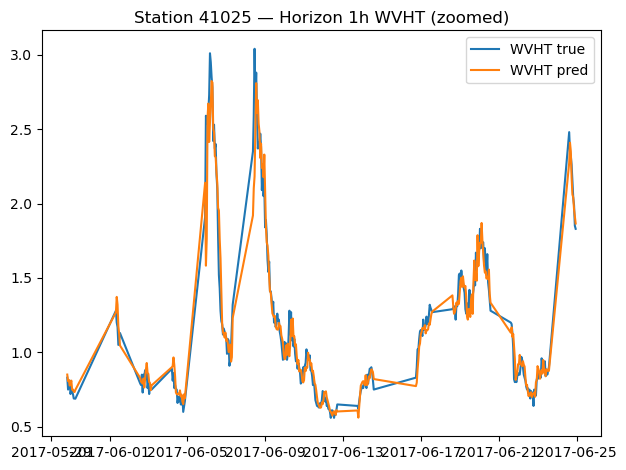

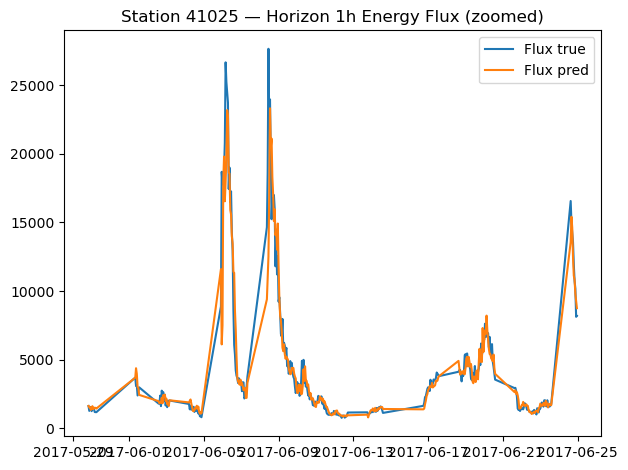

In [42]:
def plot_predictions(pred_df, title_prefix=""):
 
    zoom = pred_df.iloc[:24*14]  
    
    plt.figure()
    plt.plot(zoom.index, zoom["WVHT_true"], label="WVHT true")
    plt.plot(zoom.index, zoom["WVHT_pred"], label="WVHT pred")
    plt.title(f"{title_prefix} WVHT (zoomed)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(zoom.index, zoom["Flux_true"], label="Flux true")
    plt.plot(zoom.index, zoom["Flux_pred"], label="Flux pred")
    plt.title(f"{title_prefix} Energy Flux (zoomed)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_predictions(pred1, title_prefix="Station 41025 — Horizon 1h")


In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_predictions(pred_df, title_prefix="", days=14):
    """
    Plots WVHT + Energy Flux for the first `days` in pred_df with a clean datetime x-axis.
    """
    zoom = pred_df.iloc[:24*days].copy()

    # --- WVHT plot ---
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(zoom.index, zoom["WVHT_true"], label="WVHT true")
    ax.plot(zoom.index, zoom["WVHT_pred"], label="WVHT pred")
    ax.set_title(f"{title_prefix} — WVHT (first {days} days)")
    ax.set_ylabel("WVHT (m)")
    ax.legend()

    # Clean x-axis ticks
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Flux plot ---
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(zoom.index, zoom["Flux_true"], label="Flux true")
    ax.plot(zoom.index, zoom["Flux_pred"], label="Flux pred")
    ax.set_title(f"{title_prefix} — Energy Flux (first {days} days)")
    ax.set_ylabel("Energy Flux (W/m)")
    ax.legend()

    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


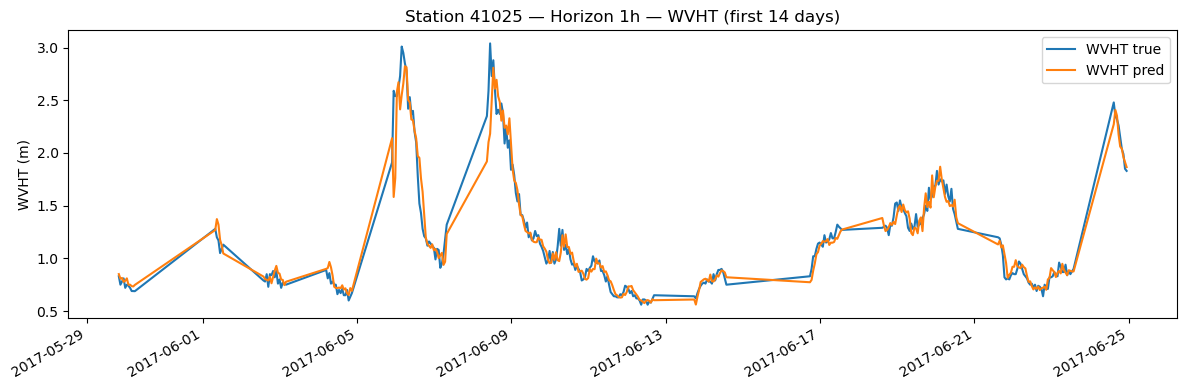

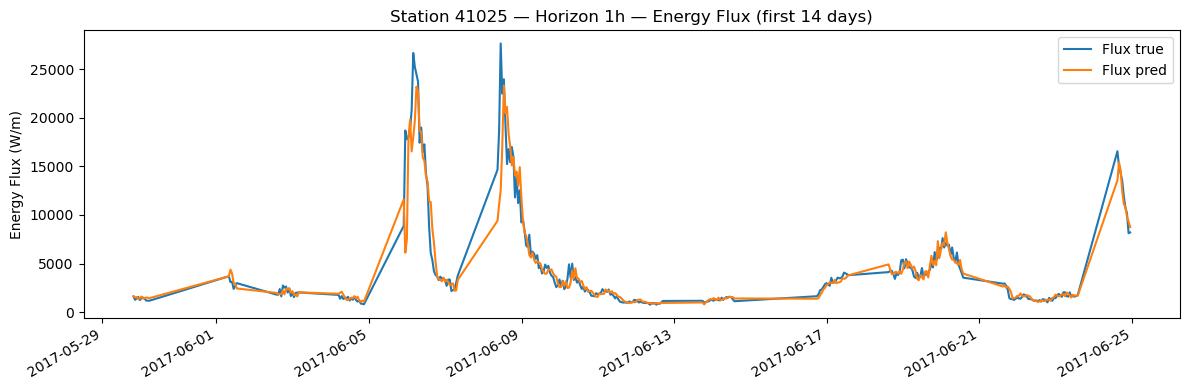

In [46]:
plot_predictions(pred1, title_prefix="Station 41025 — Horizon 1h", days=14)

In [47]:
def plot_window(pred_df, start, end, title_prefix=""):
    w = pred_df.loc[start:end]

    import matplotlib.dates as mdates

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(w.index, w["WVHT_true"], label="WVHT true")
    ax.plot(w.index, w["WVHT_pred"], label="WVHT pred")
    ax.set_title(f"{title_prefix} — WVHT ({start} to {end})")
    ax.set_ylabel("WVHT (m)")
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(w.index, w["Flux_true"], label="Flux true")
    ax.plot(w.index, w["Flux_pred"], label="Flux pred")
    ax.set_title(f"{title_prefix} — Energy Flux ({start} to {end})")
    ax.set_ylabel("Energy Flux (W/m)")
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


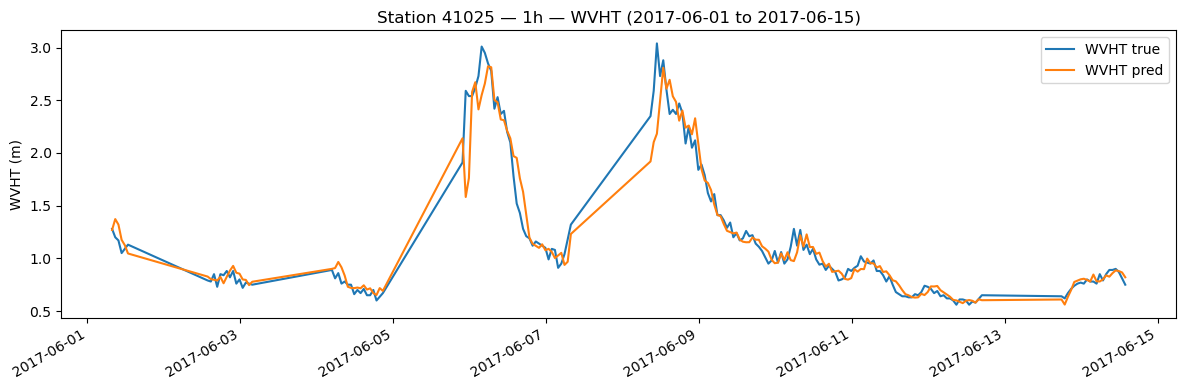

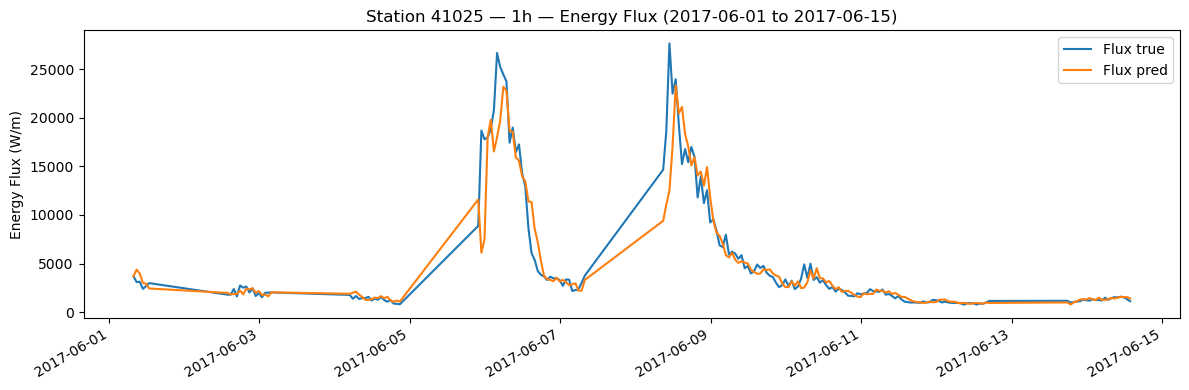

In [48]:
plot_window(pred1, "2017-06-01", "2017-06-15", title_prefix="Station 41025 — 1h")

In [ ]:
HORIZONS = [1, 6, 12, 24]

all_results = []
preds = {}

for h in HORIZONS:
    m, f, pred = run_horizon(df, horizon_h=h, L=24)
    preds[h] = pred

    row = {
        "horizon_h": h,

        "WVHT_RMSE": m["WVHT"]["RMSE_model"],
        "WVHT_MAE":  m["WVHT"]["MAE_model"],
        "WVHT_Skill_vs_persist": m["WVHT"]["Skill_vs_persist"],

        "APD_RMSE": m["APD"]["RMSE_model"],
        "APD_MAE":  m["APD"]["MAE_model"],
        "APD_Skill_vs_persist": m["APD"]["Skill_vs_persist"],

        "Flux_RMSE_Wm": f["Flux_RMSE_Wm"],
        "Flux_RelErr_%": f["Flux_RelErr_%"],
    }

    all_results.append(row)

results_41025 = pd.DataFrame(all_results).sort_values("horizon_h")
results_41025


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  


Horizon = 1h
Total supervised samples: 17390
Split summary:
 Train: (12173, 312) | 2014-01-01 23:50:00 → 2016-09-25 11:50:00
 Val  : (2608, 312) | 2016-09-25 12:50:00 → 2017-05-29 18:50:00
 Test : (2609, 312) | 2017-05-29 19:50:00 → 2017-11-07 11:50:00


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d[f"{col}_lag{lag}"] = d[col].shift(lag)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1831334272.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  


Horizon = 6h
Total supervised samples: 17360
Split summary:
 Train: (12152, 312) | 2014-01-01 23:50:00 → 2016-09-25 08:50:00
 Val  : (2604, 312) | 2016-09-25 09:50:00 → 2017-05-29 15:50:00
 Test : (2604, 312) | 2017-05-29 16:50:00 → 2017-11-07 07:50:00


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(results_41025["horizon_h"], results_41025["WVHT_RMSE"], marker="o", label="WVHT_RMSE")
plt.plot(results_41025["horizon_h"], results_41025["APD_RMSE"], marker="o", label="APD_RMSE")
plt.title("Station 41025 — RMSE vs Horizon")
plt.xlabel("Horizon (hours)")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.dates as mdates

def plot_predictions_clean(pred_df, title_prefix="", days=14):
    zoom = pred_df.iloc[:24*days].copy()

    # WVHT
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(zoom.index, zoom["WVHT_true"], label="WVHT true")
    ax.plot(zoom.index, zoom["WVHT_pred"], label="WVHT pred")
    ax.set_title(f"{title_prefix} — WVHT (first {days} days)")
    ax.set_ylabel("WVHT (m)")
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Flux
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(zoom.index, zoom["Flux_true"], label="Flux true")
    ax.plot(zoom.index, zoom["Flux_pred"], label="Flux pred")
    ax.set_title(f"{title_prefix} — Energy Flux (first {days} days)")
    ax.set_ylabel("Energy Flux (W/m)")
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


In [ ]:
for h in HORIZONS:
    plot_predictions_clean(preds[h], title_prefix=f"Station 41025 — Horizon {h}h", days=14)


In [ ]:
results_41025.to_csv("results_station_41025.csv", index=False)

for h, pdf in preds.items():
    pdf.to_csv(f"predictions_station_41025_h{h}.csv")
